Estimacion de los parámetros del modelo de $\Lambda$CDM con el algoritmo de Metropolis-Hastings usando la ecuación de Friedmann en corrimiento al rojo:

$
 H^2(z) = H_0^2 \left( \Omega_m^{0}(1+z)^{3} + \Omega_\Lambda^{0} + \Omega_k^{0}(1+z)^2\right)
$

$
\Omega_k^{0} = (1 - \Omega_m^{0} - \Omega_\Lambda^{0})
$

$
H_0 \in (50,100) , \quad \Omega_m^{0},\Omega_\Lambda^{0} \in (0,1), \quad \Omega_k^{0} \in (-0.1, 0.1)
$

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import getdist
import arviz as az
import coplot.plot_contours as plc
import math

In [2]:
#Datos de planck
planck_samples = getdist.loadMCSamples(r'Planck_Data\COM_CosmoParams_fullGrid_R3.01\base_omegak\plikHM_TTTEEE_lowl_lowE_BAO\base_omegak_plikHM_TTTEEE_lowl_lowE_BAO', settings={'ignore_rows':0.3})
planck = planck_samples.getParams()

Planck_Data\COM_CosmoParams_fullGrid_R3.01\base_omegak\plikHM_TTTEEE_lowl_lowE_BAO\base_omegak_plikHM_TTTEEE_lowl_lowE_BAO_1.txt
Planck_Data\COM_CosmoParams_fullGrid_R3.01\base_omegak\plikHM_TTTEEE_lowl_lowE_BAO\base_omegak_plikHM_TTTEEE_lowl_lowE_BAO_2.txt
Planck_Data\COM_CosmoParams_fullGrid_R3.01\base_omegak\plikHM_TTTEEE_lowl_lowE_BAO\base_omegak_plikHM_TTTEEE_lowl_lowE_BAO_3.txt
Planck_Data\COM_CosmoParams_fullGrid_R3.01\base_omegak\plikHM_TTTEEE_lowl_lowE_BAO\base_omegak_plikHM_TTTEEE_lowl_lowE_BAO_4.txt
Removed no burn in


In [5]:
#Datos Hz

z_o = [0.07, 0.09, 0.12, 0.17, 0.1791, 
     0.1993, 0.2, 0.24, 0.27, 0.28, 
     0.30, 0.31, 0.34, 0.35, 0.3519,
     0.36, 0.38, 0.3802, 0.4, 
     0.4004, 0.4247, 0.43, 0.44, 0.4497,
     0.47, 0.4783, 0.48, 0.51,
     0.52, 0.56, 0.57, 0.59, 0.5929,
     0.6, 0.61, 0.64, 0.6797, 0.73, 0.75,
     0.7812, 0.8754, 0.88, 0.9, 1.037,
     1.3, 1.363, 1.43, 1.53, 1.75,
     1.965, 2.3, 2.33, 2.34, 2.36]

H_o = [69, 69, 68.6, 83, 75,
     75, 72.9, 79.69, 77, 88.8,
     81.7, 78.18, 83.8, 82.7,
     83, 79.94, 81.5, 83, 82.04,
     77, 87.1, 86.45, 84.81, 92.8,
     89, 80.9, 87.79, 90.4, 94.35,
     93.34, 96.8, 98.48, 104, 87.9,
     97.3, 98.82, 92, 97.3,98.8, 105,
     125, 90, 117, 154, 168,
     160, 177, 140, 202, 186.5,
     224, 224, 222, 226]

sigma_o = [19.6, 12, 26.2, 8, 4,
         5, 29.6, 2.99, 14, 36.64,
         6.22, 4.74, 3.66, 8.4, 14,
         3.38, 1.9, 13.5, 2.03, 10.2,
         11.2, 3.97, 1.83, 12.9, 34,
         9, 2.03, 1.9, 2.64, 2.3,
         3.4, 3.18, 13, 6.1, 2.1,
         2.98, 8, 7, 33.6, 12, 17, 
         40, 23, 20, 17, 33.6,
         18, 14, 40, 50.4, 8,
         8, 7, 8]

In [14]:
#Metropolis Hastings

def Hz_2(z, H0, omega_m, omega_l):
    omega_k = 1 - omega_m - omega_l
    result = H0**2 * (omega_m*(1+z)**3 + omega_l + omega_k*(1+z)**2)
    return result

def log_prob(H0, omega_m, omega_l, exclude):
    obs_data = zip(z_o[:exclude], H_o[:exclude], sigma_o[:exclude])
    result = 0
    omega_k = 1 - omega_m - omega_l
    if(H0 < 50 or H0 > 100 or omega_m < 0 or omega_m > 1 or omega_l < 0 or omega_l > 1):
        return -np.inf
    if(omega_k <-0.1 or omega_k > 0.1 ):
        return -np.inf
    for z, H, s in obs_data:
        calculated_H = Hz_2(z, H0, omega_m, omega_l)
        result += -0.5*((H**2 - calculated_H)/(2*H*s))**2
    return result

def Metropolis_Hasting(N, burnin,init_H0, init_omegam, init_omegal, std_H0, std_omegam, std_omegal, exclude = None):
    
    H0 = init_H0
    omegam = init_omegam
    omegal = init_omegal
    
    sampling = []
    acceptance_rate = 0


    for i in range(N):
        next_H0 = np.random.normal(H0,std_H0)
        next_omegam = np.random.normal(omegam,std_omegam)
        next_omegal = np.random.normal(omegal,std_omegal)
    
        r = min(0, log_prob(next_H0, next_omegam,next_omegal,exclude) - log_prob(H0, omegam, omegal, exclude))
        u = np.random.uniform(0,1)
        if(np.log(u) < r):
            H0, omegam, omegal = next_H0, next_omegam,next_omegal
            acceptance_rate += 1
        sampling.append((H0, omegam, omegal))

    acceptance_rate /= N
    
    return sampling[burnin:] , acceptance_rate
    

In [37]:
#Valores iniciales
init_H0 = 65
init_omegam = 0.3
init_omegal = 0.7
std_H0 = 0.8
std_omegam = 0.025
std_omegal = 0.025

N = 35000
burnin = 5000

result_sampling, acceptance_rate = Metropolis_Hasting(N, burnin,
                                                      init_H0, init_omegam, init_omegal, 
                                                      std_H0, std_omegam, std_omegal, exclude = None)


print(np.mean(result_sampling, axis=0))
print(acceptance_rate)

H_0, omega_m, omega_l = zip(*result_sampling)

[69.39037262  0.25893013  0.70699981]
0.24957142857142858


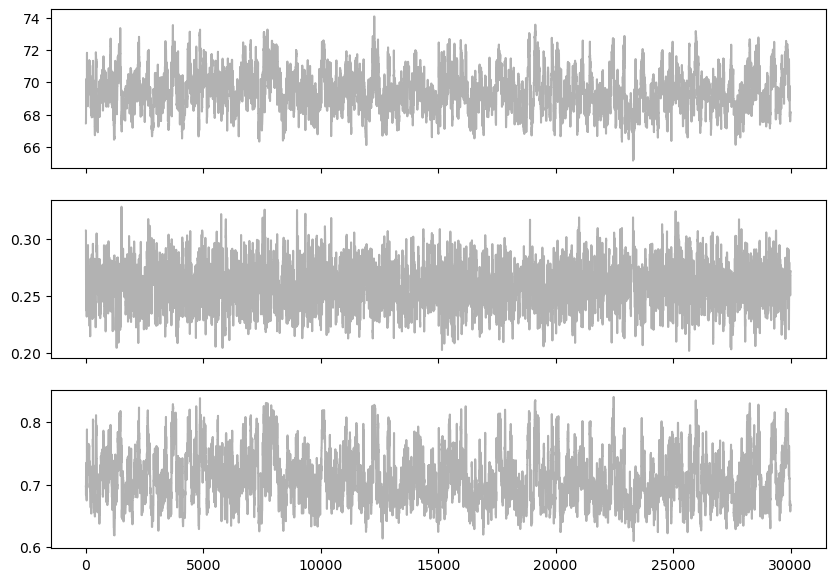

In [19]:
#Grafico del movimiento de los estados de la cadena de Markov
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot([x[i] for x in result_sampling], "k", alpha=0.3)

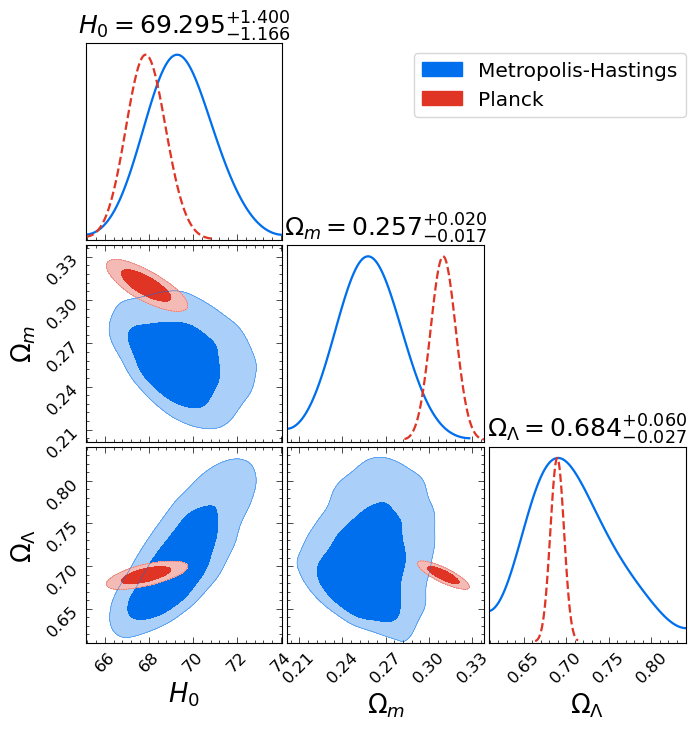

In [20]:
#Grafica de las distribuciones de Metropolis-Hastings y Planck
MH = np.stack((H_0, omega_m, omega_l), axis=1)
Planck = np.stack((planck.H0, planck.omegam, planck.omegal), axis=1)


fig = plc.Contours([MH,Planck]).plot(labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"],
                               legend=True, legend_labels=['Metropolis-Hastings', 'Planck'],subplots_adjust=True, smooth=10,
                              sigma = 2, show_titles=True)


plt.show()

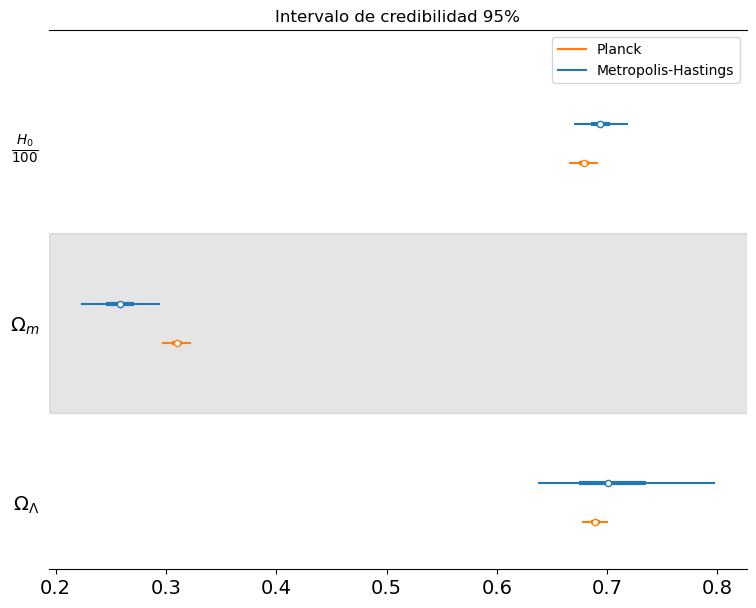

In [21]:
#Grafica de intervalos de credibilidad
MCMC = {r"$\Omega_m$": np.array(omega_m), r"$\Omega_\Lambda$": np.array(omega_l), r"$\frac{H_0}{100}$": np.array(H_0)/100}
Planck = {r"$\Omega_m$": planck.omegam,  r"$\Omega_\Lambda$": planck.omegal, r"$\frac{H_0}{100}$": planck.H0/100}
axis = az.plot_forest([MCMC, Planck],
                        model_names = ["Metropolis-Hastings", "Planck"],
                        kind='forestplot',
                        combined=True,
                        hdi_prob = 0.95 ,
                        figsize=(9, 7))
axis[0].set_title('Intervalo de credibilidad 95%')
plt.show()

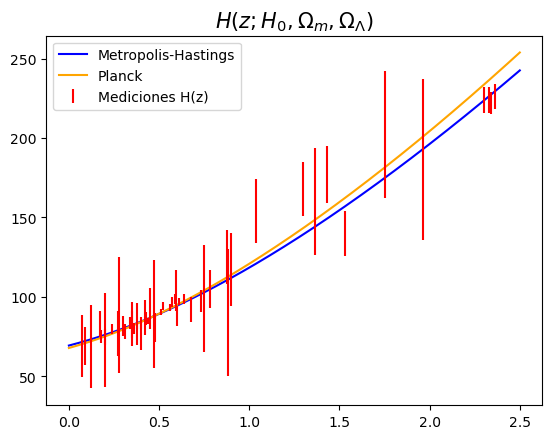

In [30]:
#Grafica de predicciones de Hz de paramtros de Planck y Metropolis-Hastings
z = np.linspace(0,2.5,1000)

MCMC_H_0, MCMC_omega_m, MCMC_omega_l = np.mean(result_sampling, axis=0)
planck_H_0, planck_omega_m, planck_omega_l = np.mean(planck.H0, axis=0), np.mean(planck.omegam, axis=0), np.mean(planck.omegal, axis=0)


plt.plot(z, np.sqrt(Hz_2(z,MCMC_H_0 , MCMC_omega_m , MCMC_omega_l)), color = "blue") #MCMC
plt.plot(z, np.sqrt(Hz_2(z,planck_H_0 , planck_omega_m , planck_omega_l)), color = "orange") #Planck
plt.errorbar(z_o, H_o, yerr = sigma_o, linestyle='', color="red")

plt.legend(labels = ['Metropolis-Hastings', 'Planck', 'Mediciones H(z)'])
plt.title(r"$H(z; H_0, \Omega_m, \Omega_\Lambda)$", fontsize=15)
plt.show()

In [38]:
#Estimacion de parametros excluyendo las últimas 4 mediciones

#Valores iniciales
init_H0 = 65
init_omegam = 0.3
init_omegal = 0.7
std_H0 = 0.9
std_omegam = 0.04
std_omegal = 0.04

N = 35000
burnin = 5000

result_sampling_ex, acceptance_rate = Metropolis_Hasting(N, burnin,
                                                      init_H0, init_omegam, init_omegal, 
                                                      std_H0, std_omegam, std_omegal, exclude = -4)


print(np.mean(result_sampling_ex, axis=0))
print(acceptance_rate)

H_0_ex, omega_m_ex, omega_l_ex = zip(*result_sampling_ex)

[66.8307204   0.33541082  0.66047703]
0.24794285714285713


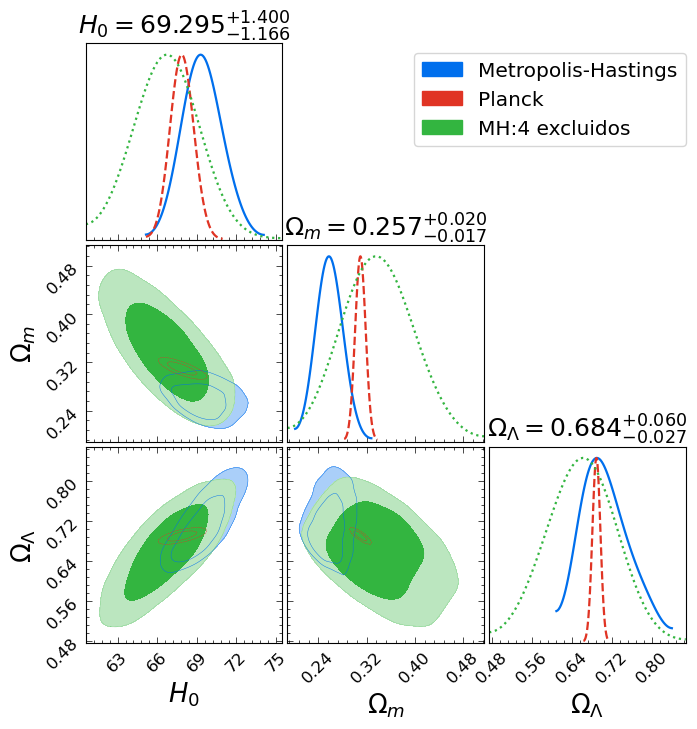

In [36]:
#Grafica de distribuciones
MH = np.stack((H_0, omega_m, omega_l), axis=1)
Planck = np.stack((planck.H0, planck.omegam, planck.omegal), axis=1)
MH_ex = np.stack((H_0_ex, omega_m_ex, omega_l_ex), axis=1)



fig = plc.Contours([MH,Planck, MH_ex]).plot(labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"],
                               legend=True, legend_labels=[ 'Metropolis-Hastings','Planck',"MH:4 excluidos"],subplots_adjust=True, smooth=10,
                              sigma = 2, show_titles=True)

plt.show()

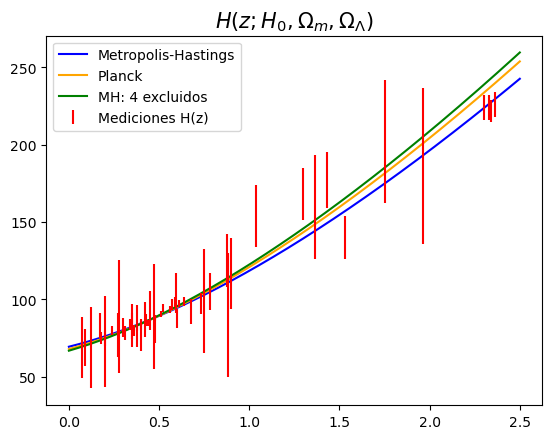

In [41]:
#Grafica de predicciones de Hz de paramtros de Planck y Metropolis-Hastings
z = np.linspace(0,2.5,1000)

MCMC_H_0, MCMC_omega_m, MCMC_omega_l = np.mean(result_sampling, axis=0)
MCMC_H_0_ex, MCMC_omega_m_ex, MCMC_omega_l_ex = np.mean(result_sampling_ex, axis=0)
planck_H_0, planck_omega_m, planck_omega_l = np.mean(planck.H0, axis=0), np.mean(planck.omegam, axis=0), np.mean(planck.omegal, axis=0)


plt.plot(z, np.sqrt(Hz_2(z,MCMC_H_0 , MCMC_omega_m , MCMC_omega_l)), color = "blue") #MCMC
plt.plot(z, np.sqrt(Hz_2(z,planck_H_0 , planck_omega_m , planck_omega_l)), color = "orange") #Planck
plt.plot(z, np.sqrt(Hz_2(z,MCMC_H_0_ex , MCMC_omega_m_ex , MCMC_omega_l_ex)), color = "green") #MCMC 4 excluidos

plt.errorbar(z_o, H_o, yerr = sigma_o, linestyle='', color="red")

plt.legend(labels = ['Metropolis-Hastings', 'Planck', 'MH: 4 excluidos','Mediciones H(z)'])
plt.title(r"$H(z; H_0, \Omega_m, \Omega_\Lambda)$", fontsize=15)
plt.show()